# HW2 - CS391L Machine Learning WB (Spring 23)
Due Date: 10th March 23, 11:59 PM (Using 1 Slack Day)

*Submission by - Sidharth Nair (sn25377)*

\*\***Refer to the problem staement pdf for question descriptions**\*\*

### **Answer1**

a) The two classes cannot be separated by a linear surface. One quadratic surface that separates the two classes is a circle that lies between the two classes:
$$ || x ||_2^2 = 2 $$

b) We assume that the probability of each class P(c1) and P(c2) are equal: P(c1) = P(c2). Then, we model each class as a multivariate gaussian with different covariance matrices, as described in the problem. Using Bayes' rule we can compute P(c1 | x) and P(c2 | x). To compute the decision boundary, we set these equal to each other. After simplification we get:
$$ (x^T \Sigma _1^{-1} x - x^T \Sigma _2^{-1} x) + log(|\Sigma _1| / |\Sigma _2|) = 0 $$
Writing this in term of $\sigma _1$ and $\sigma _2$ and simplifying gives us (assume d = 2):
$$ (x^Tx)(1/\sigma _1^2 + 1/\sigma _2^2) + log((\sigma _1 / \sigma _2)^{2d}) = 0 $$
$$ || x ||_2^2 = -4 * log((\sigma _1 / \sigma _2)) / (1/\sigma _1^2 + 1/\sigma _2^2) $$
If we set $\sigma _1 = 1$ and $\sigma _2 = 2$, then we get:
$$ || x ||_2^2 \approx 1.505 $$
which will separate the different classes completely.

### **Answer2** - implement 2 layer neural network in PyTorch on CIFAR-10 dataset

#### Imports

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler

import numpy as np
from tqdm import tqdm

#### Load CIFAR-10 dataset

In [64]:
# converts the images to 3D tensors and normalizes them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# split the training set into training (40,000 datapoints) and validation (10,000 datapoints) sets
val_inds = np.random.choice(len(trainset), 10000, replace=False)
trn_inds = np.setdiff1d(np.arange(len(trainset)), val_inds)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(trn_inds), num_workers=2)
validloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(val_inds), num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Visualize sample images

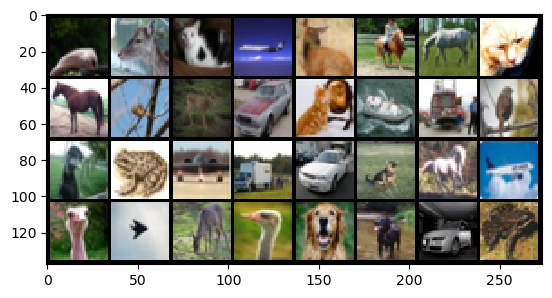

bird  deer  cat   plane deer  horse horse cat   horse bird  deer  car   cat   ship  truck bird  bird  frog  plane truck car   dog   horse plane bird  plane deer  bird  dog   dog   car   frog 


In [65]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def denormalize(img):
    img = img / 2 + 0.5 # unnormalize
    return img

def imshow(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
denormalized_images = denormalize(images)
imshow(torchvision.utils.make_grid(denormalized_images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

#### Define the network

In [66]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: define the layers of the network
        self.fc1 = nn.Linear(3 * 32 * 32, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        # TODO: define the forward pass
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

In [67]:
def eval(net, data_loader, name=''):
    # set the network to evaluation mode
    net.eval()
    accuracy = 0
    num_samples = 0
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs, labels = data
            out = net(inputs)
            accuracy += (out.argmax(dim=1) == labels).sum()
            num_samples += inputs.shape[0]
    accuracy = accuracy * 100 / num_samples
    print(f'{name} Accuracy: {accuracy:.2f}%')
    return accuracy

#### Define the loss function, learning rate and optimizer

In [68]:
import torch.optim as optim

def init_network(lr=10e-3):
    net = Net()
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr)
    return net, loss, optimizer

#### Training loop

In [69]:
NUM_EPOCHS = 10

In [70]:
def train(net, trainloader, optimizer, loss_fn, num_epochs=NUM_EPOCHS):
    # Put the network in training mode
    net.train()

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        t = tqdm(trainloader, desc='Epoch: 0, Loss: 0.0', leave=True, position=0)
        
        for i, data in enumerate(t):
            # get the inputs
            inputs, labels = data
            
            # TODO: zero the parameter gradients + forward pass + loss computation + backward pass + weight update
            optimizer.zero_grad()
            
            outputs = net.forward(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            t.set_description(f'Epoch: {epoch}/{NUM_EPOCHS}, Loss: {running_loss/(i+1):.4f}', refresh=True)

#### Save and evaluate the model

In [71]:
def save(net, name):
    torch.save(net.state_dict(), name)

#### Hyperparameter tuning of learning rate (plot the learning rate vs validation accuracy)

In [78]:
lrs = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1]
acc = []

for lr in lrs:
    net, loss, optimizer = init_network(lr)
    train(net, trainloader, optimizer, loss, NUM_EPOCHS)
    save(net, f'LR_{lr}.pth')
    acc.append(eval(net, validloader, f'LR_{lr}'))

100%|██████████| 313/313 [00:02<00:00, 132.49it/s]


LR_0.0001 Accuracy: 24.89%


100%|██████████| 313/313 [00:02<00:00, 145.00it/s]


LR_0.001 Accuracy: 33.28%


100%|██████████| 313/313 [00:02<00:00, 134.27it/s]


LR_0.01 Accuracy: 41.55%


100%|██████████| 313/313 [00:02<00:00, 138.50it/s]


LR_0.1 Accuracy: 47.29%


100%|██████████| 313/313 [00:02<00:00, 135.72it/s]

LR_1.0 Accuracy: 41.98%


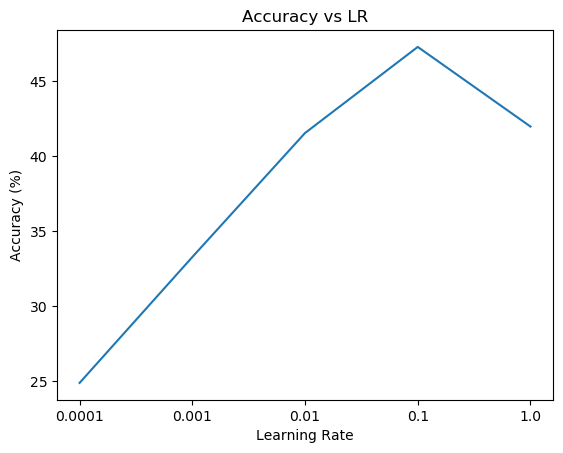

In [79]:
plt.plot(np.asarray(lrs).astype('str'), acc)
plt.title("Accuracy vs LR")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.show()

#### Report optimal learning rate and test accuracy

In [80]:
optimal_lr = None
optimal_acc = None
for i in range(len(lrs)):
    if optimal_lr is None or optimal_acc < acc[i]:
        optimal_lr = lrs[i]
        optimal_acc = acc[i].item()
print("Optimal LR:", optimal_lr, "Optimal Accuracy:", optimal_acc, "%")

Optimal LR: 0.1 Optimal Accuracy: 47.290000915527344 %


### **Answer3** - implement 2 layer neural network with numpy on CIFAR-10 dataset

In [3]:
import numpy as np

#### Load and prepare data

In [4]:
trn_data, trn_labels, val_data, val_labels, tst_data, tst_labels = np.load('cifar10_data.npy', allow_pickle=True)

In [5]:
def normalize_images(x):
    # transform 0-255 RGB values to -1 to 1
    return (x/128)-1
    
def unnormalize_images(x):
    # transform -1 to 1 image to 0-1 float RGB values
    return (x+1)/2

trn_data = normalize_images(trn_data)
val_data = normalize_images(val_data)
tst_data = normalize_images(tst_data)

#### Visualize sample train images

Text(0.5, 1.0, 'cat')

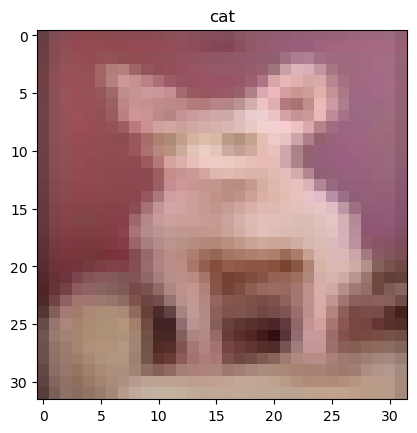

In [54]:
# reshape 3072 to 32x32x3 amd show the image
x = np.random.randint(0, trn_data.shape[0])
img = unnormalize_images(np.reshape(trn_data[x], (3, 32, 32)).transpose([1, 2, 0]))
plt.imshow(img)
plt.title(classes[trn_labels[x]])

#### Define hyperparameters (batch size, learning rate, number of epochs)

In [12]:
BATCH_SIZE = 32
NUM_EPOCHS = 10

#### Initialize weights and biases of the two layer network (W1, b1, W2, b2)

In [41]:
def init_network():
    w1 = np.random.random((3 * 32 * 32, 100))
    b1 = np.random.random((1, 100))
    w2 = np.random.random((100, 10))
    b2 = np.random.random((1, 10))
    return w1, w2, b1, b2

#### Training loop

In [43]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy_loss(y_probabilities, y_actual):
    return -np.sum(np.log(y_probabilities[range(BATCH_SIZE), y_actual])) / BATCH_SIZE

def train(w1, w2, b1, b2, LR, trn_data, trn_labels):
    for epoch in range(NUM_EPOCHS):
        # shuffle data
        idx = np.random.permutation(len(trn_data))
        trn_data = trn_data[idx]
        trn_labels = trn_labels[idx]
        running_loss = 0

        t = tqdm(range(0, len(trn_data), BATCH_SIZE), desc='Epoch: 0, Loss: 0.0', leave=True, position=0)
        for i in t:
            x = trn_data[i:i+BATCH_SIZE]
            y = trn_labels[i:i+BATCH_SIZE]
            
            # forward pass - compute z1, a1, z2, a2
            z1 = np.dot(x, w1) + b1
            a1 = sigmoid(z1)
            z2 = np.dot(a1, w2) + b2
            a2 = softmax(z2)

            # compute cross entropy loss
            loss = cross_entropy_loss(a2, y)

            # backpropagate
            dz2 = a2
            dz2[range(BATCH_SIZE), y] -= 1
            dw2 = np.dot(a1.T, dz2)
            db2 = np.sum(dz2, axis=0, keepdims=True)
            
            dz1 = np.dot(dz2, w2.T) * (a1 * (1 - a1))
            dw1 = np.dot(x.T, dz1)
            db1 = np.sum(dz1, axis=0, keepdims=True)
            
            # weight update
            w2 -= LR * dw2
            b2 -= LR * db2
            w1 -= LR * dw1
            b1 -= LR * db1
        
            running_loss += loss
            t.set_description(f'Epoch: {epoch}/{NUM_EPOCHS}, Loss: {running_loss/(i/BATCH_SIZE+1):.4f}', refresh=True)

#### Save and evaluate the model

In [48]:
def eval(w1, w2, b1, b2, data, labels, batch_size, name=''):
    accuracy = 0
    for i in range(0, len(data), batch_size):
        x = data[i:i+batch_size]
        y = labels[i:i+batch_size]
        z1 = np.dot(x, w1) + b1
        a1 = 1 / (1 + np.exp(-z1))
        z2 = np.dot(a1, w2) + b2
        a2 = np.zeros_like(z2)
        a2 = np.exp(z2) / np.sum(np.exp(z2), axis=1, keepdims=True)
        accuracy += (a2.argmax(axis=1) == y).sum()
    accuracy = accuracy * 100 / len(data)
    print(f'{name} Accuracy: {accuracy:.2f}%')
    return accuracy

In [45]:
def save_np(w1, w2, b1, b2, name):
    torch.save({"w1":w1, "w2":w2, "b1":b1, "b2":b2}, name)

#### Hyperparameter tuning of learning rate (plot the learning rate vs validation accuracy)

In [49]:
lrs = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1]
acc = []

for lr in lrs:
    w1, w2, b1, b2 = init_network()
    train(w1, w2, b1, b2, lr, trn_data, trn_labels)
    save_np(w1, w2, b1, b2, f'NP_LR_{lr}.pth')
    acc.append(eval(w1, w2, b1, b2, val_data, val_labels, BATCH_SIZE, f'NP_LR_{lr}'))

Epoch: 0/10, Loss: 4.7940:   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipykernel_44782/4095550735.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Epoch: 9/10, Loss: 2.2765: 100%|██████████| 1250/1250 [00:24<00:00, 50.46it/s]
/tmp/ipykernel_44782/159915753.py:7: RuntimeWarning: overflow encountered in exp
  a1 = 1 / (1 + np.exp(-z1))


NP_LR_0.0001 Accuracy: 14.61%


Epoch: 9/10, Loss: 2.2659: 100%|██████████| 1250/1250 [00:24<00:00, 50.32it/s]


NP_LR_0.001 Accuracy: 15.05%


Epoch: 9/10, Loss: 2.5717: 100%|██████████| 1250/1250 [00:23<00:00, 53.86it/s]


NP_LR_0.01 Accuracy: 16.30%


Epoch: 9/10, Loss: 5.7928: 100%|██████████| 1250/1250 [00:15<00:00, 79.23it/s]


NP_LR_0.1 Accuracy: 25.24%


Epoch: 0/10, Loss: 2.6993:   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipykernel_44782/4095550735.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y_probabilities[range(BATCH_SIZE), y_actual])) / BATCH_SIZE
Epoch: 0/10, Loss: inf:   0%|          | 0/1250 [00:00<?, ?it/s]   /tmp/ipykernel_44782/4095550735.py:5: RuntimeWarning: overflow encountered in exp
  exp = np.exp(x)
/tmp/ipykernel_44782/4095550735.py:6: RuntimeWarning: invalid value encountered in divide
  return exp / np.sum(exp, axis=1, keepdims=True)
Epoch: 9/10, Loss: nan: 100%|██████████| 1250/1250 [00:19<00:00, 63.39it/s]


NP_LR_1.0 Accuracy: 9.97%


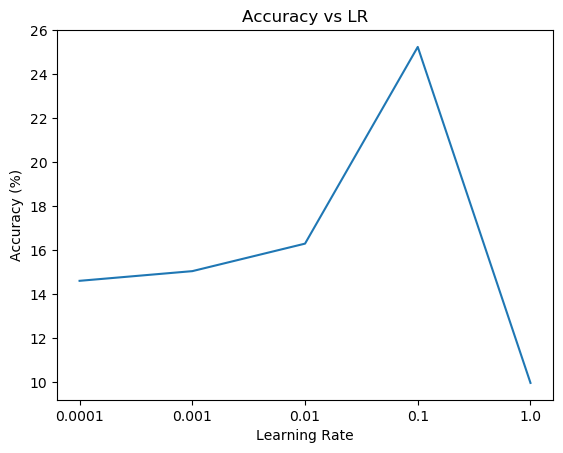

In [55]:
plt.plot(np.asarray(lrs).astype('str'), acc)
plt.title("Accuracy vs LR")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.show()

#### Report optimal learning rate and test accuracy

In [56]:
optimal_lr = None
optimal_acc = None
for i in range(len(lrs)):
    if optimal_lr is None or optimal_acc < acc[i]:
        optimal_lr = lrs[i]
        optimal_acc = acc[i].item()
print("Optimal LR:", optimal_lr, "Optimal Accuracy:", optimal_acc, "%")

Optimal LR: 0.1 Optimal Accuracy: 25.24 %


#### Try changing the initializations of your neural network weight matrices to following options: i) random values in $[-0.1, 0.1]$ ii) random values in $[-10, 10]$ iii) all zero values. Report your final test accuracies using different initializations and explain your observations. 

In [57]:
def init_network_clamped(min, max):
    w1 = np.random.uniform(low=min, high=max, size=(3 * 32 * 32, 100))
    b1 = np.random.uniform(low=min, high=max, size=(1, 100))
    w2 = np.random.uniform(low=min, high=max, size=(100, 10))
    b2 = np.random.uniform(low=min, high=max, size=(1, 10))
    return w1, w2, b1, b2

def init_network_zeros():
    w1 = np.zeros((3 * 32 * 32, 100))
    b1 = np.zeros((1, 100))
    w2 = np.zeros((100, 10))
    b2 = np.zeros((1, 10))
    return w1, w2, b1, b2

lrs = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1]
acc1 = []
acc2 = []
acc3 = []

for lr in lrs:
    w1, w2, b1, b2 = init_network_clamped(-0.1, 0.1)
    train(w1, w2, b1, b2, lr, trn_data, trn_labels)
    save_np(w1, w2, b1, b2, f'1_NP_LR_{lr}.pth')
    acc1.append(eval(w1, w2, b1, b2, val_data, val_labels, BATCH_SIZE, f'1_NP_LR_{lr}'))
    
    w1, w2, b1, b2 = init_network_clamped(-10, 10)
    train(w1, w2, b1, b2, lr, trn_data, trn_labels)
    save_np(w1, w2, b1, b2, f'2_NP_LR_{lr}.pth')
    acc2.append(eval(w1, w2, b1, b2, val_data, val_labels, BATCH_SIZE, f'2_NP_LR_{lr}'))
    
    w1, w2, b1, b2 = init_network_zeros()
    train(w1, w2, b1, b2, lr, trn_data, trn_labels)
    save_np(w1, w2, b1, b2, f'3_NP_LR_{lr}.pth')
    acc3.append(eval(w1, w2, b1, b2, val_data, val_labels, BATCH_SIZE, f'3_NP_LR_{lr}'))

Epoch: 9/10, Loss: 1.8060: 100%|██████████| 1250/1250 [00:19<00:00, 64.79it/s]


1_NP_LR_0.0001 Accuracy: 36.08%


Epoch: 0, Loss: 0.0:   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipykernel_44782/4095550735.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
Epoch: 9/10, Loss: 30.3643: 100%|██████████| 1250/1250 [00:21<00:00, 58.83it/s]
/tmp/ipykernel_44782/159915753.py:7: RuntimeWarning: overflow encountered in exp
  a1 = 1 / (1 + np.exp(-z1))


2_NP_LR_0.0001 Accuracy: 14.80%


Epoch: 9/10, Loss: 2.2944: 100%|██████████| 1250/1250 [00:21<00:00, 57.30it/s]


3_NP_LR_0.0001 Accuracy: 11.76%


Epoch: 9/10, Loss: 1.5134: 100%|██████████| 1250/1250 [00:22<00:00, 55.75it/s]


1_NP_LR_0.001 Accuracy: 44.88%


Epoch: 9/10, Loss: 14.2336: 100%|██████████| 1250/1250 [00:23<00:00, 52.13it/s]


2_NP_LR_0.001 Accuracy: 21.01%


Epoch: 9/10, Loss: 2.0427: 100%|██████████| 1250/1250 [00:21<00:00, 57.98it/s]


3_NP_LR_0.001 Accuracy: 18.33%


Epoch: 9/10, Loss: 1.2813: 100%|██████████| 1250/1250 [00:20<00:00, 61.74it/s]


1_NP_LR_0.01 Accuracy: 45.02%


Epoch: 9/10, Loss: 2.0157: 100%|██████████| 1250/1250 [00:20<00:00, 61.85it/s]


2_NP_LR_0.01 Accuracy: 26.72%


Epoch: 9/10, Loss: 2.0749: 100%|██████████| 1250/1250 [00:19<00:00, 62.87it/s]


3_NP_LR_0.01 Accuracy: 18.37%


Epoch: 9/10, Loss: 2.9737: 100%|██████████| 1250/1250 [00:16<00:00, 76.99it/s] 


1_NP_LR_0.1 Accuracy: 30.22%


Epoch: 9/10, Loss: 5.9993: 100%|██████████| 1250/1250 [00:20<00:00, 60.26it/s]


2_NP_LR_0.1 Accuracy: 25.51%


Epoch: 9/10, Loss: 2.2990: 100%|██████████| 1250/1250 [00:21<00:00, 58.79it/s]


3_NP_LR_0.1 Accuracy: 13.92%


Epoch: 0/10, Loss: 53.7059:   0%|          | 0/1250 [00:00<?, ?it/s]/tmp/ipykernel_44782/4095550735.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y_probabilities[range(BATCH_SIZE), y_actual])) / BATCH_SIZE
Epoch: 3/10, Loss: inf:  36%|███▌      | 447/1250 [00:08<00:16, 50.06it/s]    /tmp/ipykernel_44782/4095550735.py:5: RuntimeWarning: overflow encountered in exp
  exp = np.exp(x)
/tmp/ipykernel_44782/4095550735.py:6: RuntimeWarning: invalid value encountered in divide
  return exp / np.sum(exp, axis=1, keepdims=True)
Epoch: 9/10, Loss: nan: 100%|██████████| 1250/1250 [00:18<00:00, 65.96it/s]


1_NP_LR_1.0 Accuracy: 9.97%


Epoch: 9/10, Loss: inf: 100%|██████████| 1250/1250 [00:20<00:00, 60.27it/s]  


2_NP_LR_1.0 Accuracy: 13.34%


Epoch: 9/10, Loss: nan: 100%|██████████| 1250/1250 [00:17<00:00, 72.25it/s]


3_NP_LR_1.0 Accuracy: 9.97%


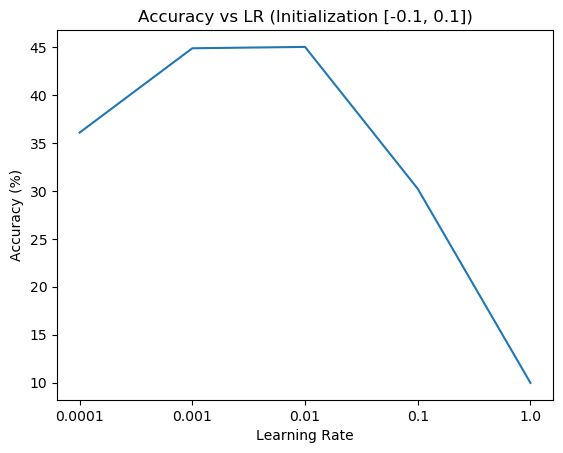

In [58]:
plt.plot(np.asarray(lrs).astype('str'), acc1)
plt.title("Accuracy vs LR (Initialization [-0.1, 0.1])")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.show()

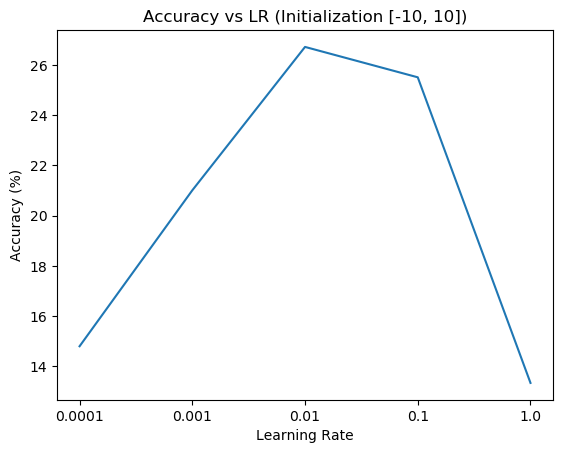

In [59]:
plt.plot(np.asarray(lrs).astype('str'), acc2)
plt.title("Accuracy vs LR (Initialization [-10, 10])")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.show()

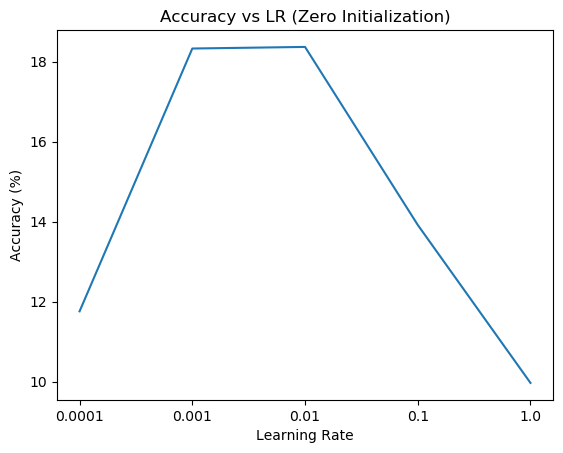

In [60]:
plt.plot(np.asarray(lrs).astype('str'), acc3)
plt.title("Accuracy vs LR (Zero Initialization)")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.show()

In [61]:
optimal_lr = None
optimal_acc = None
for i in range(len(lrs)):
    if optimal_lr is None or optimal_acc < acc1[i]:
        optimal_lr = lrs[i]
        optimal_acc = acc1[i].item()
print("[-0.1, 0.1] Initialization Optimal LR:", optimal_lr, "Optimal Accuracy:", optimal_acc, "%")

optimal_lr = None
optimal_acc = None
for i in range(len(lrs)):
    if optimal_lr is None or optimal_acc < acc2[i]:
        optimal_lr = lrs[i]
        optimal_acc = acc2[i].item()
print("[-10, 10] Initialization Optimal LR:", optimal_lr, "Optimal Accuracy:", optimal_acc, "%")

optimal_lr = None
optimal_acc = None
for i in range(len(lrs)):
    if optimal_lr is None or optimal_acc < acc3[i]:
        optimal_lr = lrs[i]
        optimal_acc = acc3[i].item()
print("Zero Initializaiton Optimal LR:", optimal_lr, "Optimal Accuracy:", optimal_acc, "%")

[-0.1, 0.1] Initialization Optimal LR: 0.01 Optimal Accuracy: 45.02 %
[-10, 10] Initialization Optimal LR: 0.01 Optimal Accuracy: 26.72 %
Zero Initializaiton Optimal LR: 0.01 Optimal Accuracy: 18.37 %


We see that initializing the network with random values between -0.1 and 0.1 results in test accuracy similar to the pytorch implementation. The other two initializations didn't do very well in comparison. A quick google search shows me that pytorch initializes linear layers as follows:

```[python]
stdv = 1. / math.sqrt(self.weight.size(1))
self.weight.data.uniform_(-stdv, stdv)
if self.bias is not None:
    self.bias.data.uniform_(-stdv, stdv)
```
For the hidden layer (100 neurons), this would result in the same initialization as random values between -0.1 and 0.1